# Pobranie Danych

dane zostały poprane ze strony [macrotrends.net](https://www.macrotrends.net/stocks) przy pomocy skryptu `scrape.py` i umieszczone kolejno w folderach `balance-sheet`, `cash-flow-statement`, `financial-ratios`, `income-statement`.
Kazdy folder posiada pliki csv z odpowiadającym raportem finansowym dla kazdej z firm indeksu S&P500. Firmy z indeksu S&P zostały pobrane z publicznego repozytrium github - [link](https://github.com/datasets/s-and-p-500-companies/blob/main/data/constituents.csv)

# Oczyszczanie danych i Transfomracje na danych

Zbiorcze dane z raportów finansowych (`balance-sheet`, `cash-flow-statement`, `financial-ratios`, `income-statement`) zostały umieszczone w oddzielnych plikach dla danego typu raportu i danej firmy. 
Dlatego przed przystąpieniem do analizy nalezy dane połączyć do zbiorczych plików CSV które będą zawierać raporty dla wszystkich firm z indeksu.

In [18]:
import pandas as pd
import glob
import numpy as np
import os
from datetime import datetime


NOT_INCLUDE = [
    #'BF.B',
    #'BRK.B',
    'GOOG',
    'FOX',
    'NWS'
]

constituents = pd.read_csv('sp500/constituents.csv')

constituents['Date added'] = pd.to_datetime(constituents['Date added'])
constituents = constituents.loc[~constituents['Symbol'].isin(NOT_INCLUDE)] # remove classes other than A
selected_companies = set(constituents['Symbol'].to_list())

folders = [
    "financial-ratios",
    "balance-sheet",
    "income-statement",
    "cash-flow-statement"
]

df = None

for ticker in selected_companies:
    all_files_exists = all(
        [os.path.isfile(f"sp500/{folder}/{ticker}.csv") for folder in folders]
    )
    if not all_files_exists:
        continue

    ticker_df = None
    
    ticker_constituent = constituents.loc[constituents['Symbol'] == ticker]
    sector = ticker_constituent['GICS Sector'].values[0]
    sub_industry = ticker_constituent['GICS Sub-Industry'].values[0]
    
    for folder in folders:
        file_path = f"sp500/{folder}/{ticker}.csv"
        new_df = pd.read_csv(file_path)
        new_df = new_df.rename(columns={'Unnamed: 0': 'date'})
        new_df['date'] = pd.to_datetime(new_df['date'])
        new_df.fillna(0, inplace=True)
        #new_df = new_df[(new_df['date'].dt.month.eq(12))]
        new_df['ticker'] = ticker
        
        new_df.set_index(['ticker', 'date'], inplace=True)
        
        if ticker_df is None:
            ticker_df = new_df
            continue    

        ticker_df = ticker_df.merge(new_df, left_index=True, right_on=['ticker', 'date'])
    
    ticker_df['sector'] = sector
    ticker_df['sub_industry'] = sub_industry
    
    if df is None:    
        df = ticker_df
        continue        
    
    df = pd.concat([df, ticker_df])

len(df.reset_index()['ticker'].unique())

494

# Pobieranie danych dot. cen z yahoo finance

Tworzymy dataframe z cenami zamknięcie na koniec kwartałów Q1, Q2, Q3, Q4

In [19]:
import yfinance as yf
start_date = df.reset_index()['date'].min().strftime('%Y-%m-%d')
end_date = df.reset_index()['date'].max().strftime('%Y-%m-%d')
ticks = yf.Tickers(list(t.replace(".", "-") for t in selected_companies))
sp500_close = ticks.history(start=start_date, end=end_date, interval="1wk").Close
sp500_close_index = yf.Tickers('^GSPC').history(start=start_date, end=end_date, interval="1wk").Close
sp500_close = sp500_close.merge(sp500_close_index, left_index=True, right_on='Date')
sp500_close = sp500_close.rename(
    columns={"BRK-B": "BRK.B", "BF-B": "BF.B", "^GSPC": "S&P500"}
)

sp500_close = sp500_close.resample("ME").apply(lambda ser: ser.iloc[-1,])
sp500_close = sp500_close.reset_index()
mask = sp500_close['Date'].dt.month.isin([3,6,9,12])
sp500_close = sp500_close.loc[mask].set_index(keys=['Date'], drop=True)

[*********************100%***********************]  500 of 500 completed

1 Failed download:
['BRK-B']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))
[*********************100%***********************]  1 of 1 completed


# Korygowanie danych o inflację

<Axes: xlabel='date'>

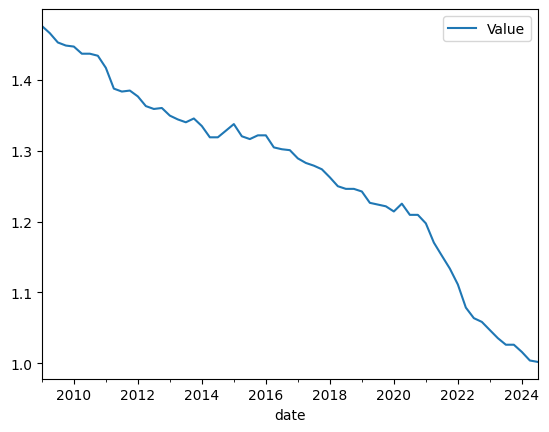

In [20]:
#https://data.bls.gov/pdq/SurveyOutputServlet

inflation_df = pd.read_csv('sp500/inflation_rates.csv').drop(columns=['Series Id'])
inflation_df['Year'] = inflation_df['Year'].astype("int")
inflation_periods = [f"M0{i}" for i in range(1, 10)] + [f"M{i}" for i in range(10, 13)]
inflation_df = inflation_df.loc[inflation_df['Period'].isin(inflation_periods)]
inflation_df = inflation_df.loc[inflation_df['Year'] > 2008]
inflation_df['Month'] = inflation_df['Period'].apply(lambda x: x.replace("M0", "").replace("M", ""))
inflation_df['Month'] = inflation_df['Month'].astype("int")

inflation_df['date'] = pd.to_datetime(dict(year=inflation_df['Year'], month=inflation_df['Month'], day=1))
inflation_df = inflation_df.loc[inflation_df['date'] <= end_date]
inflation_df = inflation_df.drop(columns=['Year', 'Period', 'Month']).set_index(keys=['date'], drop=True)

inflation_df['Value'] = inflation_df['Value'] / 100
inflation_df['Value'] = 1.0 + inflation_df['Value']
inflation_df['Value'] = inflation_df.loc[::-1, 'Value'].cumprod()[::-1]

inflation_df = inflation_df.reset_index()
inflation_df = inflation_df.loc[inflation_df['date'].dt.month.isin([3,6,9,12])]
inflation_df = inflation_df.set_index('date', drop=True)
inflation_df.plot()

In [21]:
from tqdm import tqdm


metrics_in_usd = open("sp500/metrics_in_usd.txt").read().splitlines()

def adjust_values(X, Y, columns_list, date_col='date', ticker_col='ticker', index=['ticker', 'date']):
    X_adjusted = X.copy()
    X_adjusted = X_adjusted.reset_index()
    Y_reset = Y.reset_index()

    def get_matching_value(date):
        try:
            matching_value = Y_reset.loc[Y_reset['date'].dt.year == date.year].loc[Y_reset['date'].dt.quarter <= date.quarter]['Value'].iloc[-1]
        except IndexError as e:
            print(date, Y_reset.tail())
            raise e
        return matching_value
    
    for col in tqdm(columns_list):
        if col in X_adjusted.columns:
            corresponding_values = X_adjusted[date_col].map(get_matching_value)
            X_adjusted[col] = X_adjusted[col] * corresponding_values
    X_adjusted = X_adjusted.set_index(index)
    return X_adjusted

df_adjusted = adjust_values(df, inflation_df, metrics_in_usd)
sp500_close_adjusted = adjust_values(
    sp500_close,
    inflation_df,
    sp500_close.columns.to_list(),
    date_col='Date',
    ticker_col='Ticker',
    index=['Date']
)


 30%|███       | 20/66 [03:08<07:13,  9.43s/it]


KeyboardInterrupt: 

In [252]:
sp500_close_adjusted

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,S&P500
Date,,,,,,,,,,,,,,,,,,,,,
2009-03-31,15.539326,5.158703,NaN,NaN,21.750939,8.901605,30.831247,35.666928,20.935414,28.360526,...,9.958342,26.539741,15.408952,58.013771,NaN,23.667039,47.346123,29.717518,NaN,1243.766037
2009-06-30,18.487277,6.184060,NaN,NaN,22.864570,9.008417,36.185065,40.520093,25.103244,26.009173,...,9.463907,29.696971,15.638270,56.349055,NaN,26.709696,51.315967,34.700095,NaN,1314.146967
2009-09-30,24.445421,8.093406,NaN,NaN,24.620724,10.292797,40.580624,47.002098,26.639429,27.756624,...,11.165936,59.604397,16.453356,54.620844,NaN,25.756448,65.122099,36.482929,NaN,1489.552436
2009-12-31,28.781648,9.196413,NaN,NaN,26.805384,10.950704,45.643156,53.278557,32.152107,30.611112,...,13.708958,54.314741,18.336297,56.098786,NaN,27.253073,74.521164,41.067079,NaN,1615.305057
2010-03-31,31.973558,10.287679,NaN,NaN,26.459731,11.562123,45.971391,51.720634,29.512237,28.575943,...,14.493737,72.124114,18.686403,55.928906,NaN,30.698415,75.555519,43.312773,NaN,1704.870590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30,113.545643,174.621449,NaN,140.814843,96.407367,77.787466,308.910843,523.296292,175.864044,74.245467,...,30.365104,93.536017,56.078323,115.631323,92.100400,125.128681,113.711588,242.744210,175.845910,4400.707178
2023-12-31,141.460760,196.625722,NaN,139.717283,110.173921,72.478962,354.433023,612.276540,200.378312,71.536332,...,34.643351,92.489208,60.674985,99.222504,116.083883,131.476801,123.585867,280.512144,199.965208,4895.164558
2024-03-31,146.833322,173.611977,NaN,167.615248,113.182932,89.315941,347.882829,512.722184,198.552508,62.180794,...,35.782140,102.991643,53.160238,115.276475,130.265694,138.824091,132.960374,306.292062,170.119347,5338.925537


# Porównianie danych po uwzlędnieniu inflacji

<Axes: label='price', xlabel='Date'>

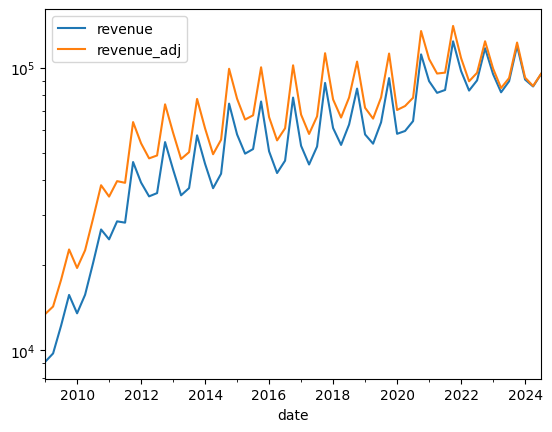

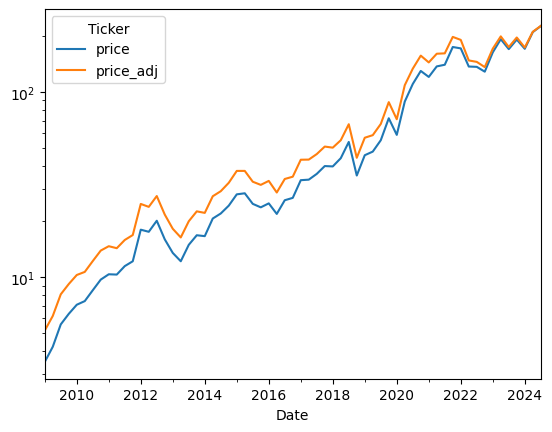

In [ ]:
ticker = "AAPL"
dff = df.reset_index()
dff = dff.loc[dff['ticker'] == ticker]
ax1 = dff[['date', 'revenue']].set_index(keys=['date']).plot(logy=True)
dff_adjusted = df_adjusted.rename(columns={"revenue": 'revenue_adj'}).reset_index()
dff_adjusted = dff_adjusted.loc[dff_adjusted['ticker'] == ticker]
dff_adjusted[['date', 'revenue_adj']].set_index(keys=['date']).plot(ax=ax1, logy=True)

dff = sp500_close.reset_index()
ax2 = dff[['Date', ticker]].rename(columns={ticker: 'price'}).set_index(keys=['Date']).plot(logy=True)
ax2.set_label("price")
dff = sp500_close_adjusted.reset_index()
dff[['Date',ticker]].rename(columns={ticker: 'price_adj'}).set_index(keys=['Date']).plot(ax=ax2, logy=True)

In [254]:
df_adjusted.head(5)

current_ratio  long_term_debt_capital  debt_equity_ratio  \
ticker date                                                                   
DRI    2024-08-31         0.3526                  0.3926             0.7835   
       2024-05-31         0.3753                  0.3793             0.6498   
       2024-02-29         0.3857                  0.3863             0.7022   
       2023-11-30         0.3643                  0.4015             0.8425   
       2023-08-31         0.3991                  0.4075             0.7321   

                   gross_margin  operating_margin  ebit_margin  \
ticker date                                                      
DRI    2024-08-31       20.4135            9.7642       9.7642   
       2024-05-31       22.2061           13.3703      13.3703   
       2024-02-29       21.7023           13.0227      13.0227   
       2023-11-30       20.1738           10.2116      10.2116   
       2023-08-31       20.4241            9.2617       9.2617   

                   pre_tax_profit_margin  net_profit_margin  asset_turnover  \
ticker date                                                                   
DRI    2024-08-31                 8.4186             7.5154          0.2428   
       2024-05-31                12.1733            10.4183          0.2612   
       2024-02-29                11.7958            10.5184          0.2619   
       2023-11-30                 8.8512             7.7769          0.2409   
       2023-08-31                 8.1740             7.1230          0.2423   

                   inventory_turnover  ...  net_cash_flow  \
ticker date                            ...                  
DRI    2024-08-31              7.3705  ...      -3.206397   
       2024-05-31              7.9194  ...     -48.192192   
       2024-02-29              7.8109  ...      48.975840   
       2023-11-30              7.0093  ...     -21.141296   
       2023-08-31              7.5711  ...    -180.316061   

                   stock_based_compensation  common_stock_dividends_paid  \
ticker date                                                                
DRI    2024-08-31                 34.769365                  -166.331834   
       2024-05-31                 10.742843                  -156.925825   
       2024-02-29                 14.225348                  -158.917457   
       2023-11-30                 13.854733                  -161.330667   
       2023-08-31                 31.096054                  -162.664176   

                                   sector  sub_industry  \
ticker date                                               
DRI    2024-08-31  Consumer Discretionary   Restaurants   
       2024-05-31  Consumer Discretionary   Restaurants   
       2024-02-29  Consumer Discretionary   Restaurants   
       2023-11-30  Consumer Discretionary   Restaurants   
       2023-08-31  Consumer Discretionary   Restaurants   

                   long_term_investments  net_change_in_long_term_investments  \
ticker date                                                                     
DRI    2024-08-31                    NaN                                  NaN   
       2024-05-31                    NaN                                  NaN   
       2024-02-29                    NaN                                  NaN   
       2023-11-30                    NaN                                  NaN   
       2023-08-31                    NaN                                  NaN   

                   research_development_expenses  \
ticker date                                        
DRI    2024-08-31                            NaN   
       2024-05-31                            NaN   
       2024-02-29                            NaN   
       2023-11-30                            NaN   
       2023-08-31                            NaN   

                   net_change_in_intangible_assets  other_income  
ticker date                                                       
DRI   

# Dodanie atrybutów decyzyjnych

* `log_retuns_q1`, `log_retuns_q2`, `log_retuns_q3`, `log_retuns_q4` - dodanie logarytmów ze zwrotów w przyszłych kwartałach - korzystam z logarytmów ponieważ operujemy w dziedzinie zwrotów, która jest multiplikatywna. Przez logarytmowanie zamieniamy multiplikatywność na addytywność. Więcej na temat dlaczego to robię zamieszczam w [linku do artykułu medium](https://medium.com/@manojkotary/simple-returns-vs-log-returns-a-comprehensive-comparative-analysis-for-financial-analysis-702403693bad)
* dodatkowo definiuję klasy binarne: 
    - `class_1_q1`, `class_1_q2`, `class_1_q3`, `class_1_q4` - 1 - jeśli `log_return_qX` > 0 - tzn. jeśli spółka zanotuje wzrost
    - `class_2_q1`, `class_2_q2`, `class_2_q3`, `class_2_q4` - 1 - jeśli `log_return_qX` > log_return_qX(SP&500) - tzn. jeśli spółka zanotuje wzrost większy niż S&P500
    - `diff_q1`, `diff_q2`, `diff_q3`, `diff_q4` - różnica pomiędzy zwrotami z S&P500 - lepsze w ocenie korelacji

In [255]:
import numpy as np

HORIZON = 4

def calculate_log_returns(df, shift=1):
    returns_df = df.copy()
    returns_df = np.log(df.shift(-shift)/df)
    returns_df = returns_df.dropna(how='all')
    return returns_df


log_returns = [None] * (HORIZON + 1)


for i in range(1, HORIZON + 1):
    log_returns[i] = pd.melt(
        calculate_log_returns(sp500_close, i).reset_index(),
        id_vars=['Date'],
        value_vars=list(sp500_close.columns),
        var_name='ticker',
        value_name=f'log_return_q{i}'
    ).rename(columns={"Date": 'date'}).set_index(['date', 'ticker']).sort_index()


target = pd.melt(
    sp500_close.reset_index(),
    id_vars=['Date'],
    value_vars=list(sp500_close.columns),
    var_name='ticker',
    value_name='price'
).rename(columns={"Date": 'date'}).set_index(['date', 'ticker']).sort_index()


for i in range(1, HORIZON + 1):
    target[f'log_return_q{i}'] = log_returns[i][f'log_return_q{i}']
    target[f'class_1_q{i}'] = (target[f'log_return_q{i}'] > 0) * 1

for i in range(len(target)):
    idx = target.index[i]
    spx_idx = (idx[0], 'S&P500')

    for i in range(1, HORIZON + 1):
        spx_return = target.at[spx_idx, f'log_return_q{i}']
        stock_return = target.at[idx, f'log_return_q{i}']
        target.at[idx, f'diff_q{i}'] = stock_return - spx_return
        target.at[idx, f'class_2_q{i}'] = (stock_return > spx_return) * 1

for i in range(1, HORIZON + 1):
    target[f'class_2_q{i}'] = target[f'class_2_q{i}'].astype('int')

target = target.dropna(subset = ['log_return_q1'])

In [256]:
columns =  ['price'] + [f'log_return_q{i}'for i in range(1, HORIZON + 1)] + [f'class_1_q{i}'for i in range(1, HORIZON + 1)]  +  [f'class_2_q{i}'for i in range(1, HORIZON + 1)] +  [f'diff_q{i}'for i in range(1, HORIZON + 1)]
target = target.reindex(columns, axis=1)

In [257]:
t = target.reset_index()
t.loc[t['ticker'] == 'AAPL'].head()

,date,ticker,price,log_return_q1,log_return_q2,log_return_q3,log_return_q4,class_1_q1,class_1_q2,class_1_q3,class_1_q4,class_2_q1,class_2_q2,class_2_q3,class_2_q4,diff_q1,diff_q2,diff_q3,diff_q4
1,2009-03-31,AAPL,3.494393,0.188281,0.466312,0.597074,0.710201,1,1,1,1,1,1,1,1,0.126246,0.270033,0.316748,0.374916
427,2009-06-30,AAPL,4.218337,0.278030,0.408793,0.521920,0.567360,1,1,1,1,1,1,1,1,0.143787,0.190502,0.248670,0.435685
853,2009-09-30,AAPL,5.570426,0.130762,0.243889,0.289330,0.423934,1,1,1,1,1,1,1,1,0.046716,0.104884,0.291898,0.312345
1280,2009-12-31,AAPL,6.348597,0.113127,0.158568,0.293172,0.425712,1,1,1,1,1,1,1,1,0.058168,0.245183,0.265629,0.305419
1710,2010-03-31,AAPL,7.108994,0.045441,0.180045,0.312585,0.378564,1,1,1,1,1,1,1,1,0.187015,0.207461,0.247251,0.255477


In [22]:
df.to_csv("sp500/data.csv")
target.to_csv("sp500/target.csv")

#target = pd.read_csv("sp500/target.csv")
#target['date'] = pd.to_datetime(target['date'])
#target = target.set_index(['date', 'ticker'], drop=True)
#df = pd.read_csv("sp500/data.csv")
#df['date'] = pd.to_datetime(df['date'])
#df = df.set_index(['date', 'ticker'], drop=True)

## Transformacje na danych

* zamiana kwartału na integer - dla uproszczeń
* wypełnienie brakujących atrybutów zerami
* eliminacja firm z krótką historią publikacji tzn. poniżej 20 kwartałów

In [23]:
def date_to_quarter_int(x):
    return 4*(x.year - 2009) + x.quarter - 1

Y = pd.read_csv('sp500/target.csv')
Y['date'] = pd.to_datetime(Y['date'])
start_date = Y['date'].min()

Y['quarter'] = Y['date'].apply(date_to_quarter_int)
Y = Y.set_index(keys=['quarter', 'ticker'], drop=True).sort_index()

X = pd.read_csv('sp500/data.csv')
X['date'] = pd.to_datetime(X['date'])
X = X.loc[X['date'] >= start_date]
X['quarter'] = X['date'].apply(date_to_quarter_int)
X = X.set_index(keys=['quarter', 'ticker'], drop=True).sort_index()


X = X.drop(columns=['date'])
Y = Y.drop(columns=['date'])
df = X.join(Y)

## We need companies with at least 4 years of history

df = df.reset_index()
quarter_counts = df.groupby('ticker')['quarter'].nunique()
valid_tickers = quarter_counts[quarter_counts >= 20].index
df = df.loc[df['ticker'].isin(valid_tickers)]
df = df.set_index(keys=['quarter', 'ticker'], drop=True).sort_index()

features = X.columns.to_list()
target_features = Y.columns.to_list()

## Uzpupełnienie danych
* market_cap
* gross_margin
* operating_margin
* free_cash_flow_per_share 
* current_ratio
* ebit
* ebitda

In [24]:
import math

df['market_cap'] = df['price']*df['net_income']/df['eps_basic_net_earnings_per_share']

def recompute_market_cap(basic_shares_outstanding, price, market_cap):
    if not math.isnan(basic_shares_outstanding) and basic_shares_outstanding > 0.0:
        return price * basic_shares_outstanding
    return market_cap

df['market_cap'] = df[['basic_shares_outstanding', 'price', 'market_cap']].apply(lambda x : recompute_market_cap(*x), axis=1)
df = df.dropna(subset=["market_cap"])

def recompute_gross_margin(revenue, cost_goods_sold, gross_margin):
    if math.isnan(gross_margin) and revenue:
        return ((revenue - cost_goods_sold) / revenue) * 100
    return gross_margin

df['gross_margin'] = df[['revenue', 'cost_goods_sold', 'gross_margin']].apply(
    lambda x: recompute_gross_margin(*x), axis=1
)

def recompute_operating_margin(revenue, operating_income, operating_margin):
    if operating_margin:
        return operating_margin
    else:
        if revenue:
            return (operating_income / revenue) * 100
    return operating_margin

df['operating_margin'] = df[['revenue', 'operating_income', 'operating_margin']].apply(
    lambda x: recompute_operating_margin(*x), axis=1
)


def compute_fcf(cash_flow_from_operating_activities, net_change_in_property_plant_equipment):

    if (not math.isnan(cash_flow_from_operating_activities) and 
        not math.isnan(net_change_in_property_plant_equipment)):
        return cash_flow_from_operating_activities + net_change_in_property_plant_equipment  # Note: net_change is usually negative
    return np.nan

def recompute_fcf_per_share(cash_flow_from_operating_activities, net_change_in_property_plant_equipment, 
                           basic_shares_outstanding, free_cash_flow_per_share):

    if not math.isnan(basic_shares_outstanding) and basic_shares_outstanding > 0.0:
        fcf = compute_fcf(cash_flow_from_operating_activities, net_change_in_property_plant_equipment)
        if not math.isnan(fcf):
            return fcf / basic_shares_outstanding
    return free_cash_flow_per_share


df['free_cash_flow_per_share'] = df[['cash_flow_from_operating_activities', 
                                    'net_change_in_property_plant_equipment',
                                    'basic_shares_outstanding', 
                                    'free_cash_flow_per_share']].apply(
    lambda x: recompute_fcf_per_share(*x), axis=1
)

def compute_current_ratio(total_current_assets, total_current_liabilities):

    if (not math.isnan(total_current_assets) and 
        not math.isnan(total_current_liabilities) and 
        total_current_liabilities > 0.0):
        return total_current_assets / total_current_liabilities
    return np.nan

def recompute_current_ratio(total_current_assets, total_current_liabilities, current_ratio):

    if (not math.isnan(total_current_assets) and 
        not math.isnan(total_current_liabilities) and 
        total_current_liabilities > 0.0):
        return compute_current_ratio(total_current_assets, total_current_liabilities)
    return current_ratio


df['current_ratio'] = df[['total_current_assets', 
                         'total_current_liabilities', 
                         'current_ratio']].apply(
    lambda x: recompute_current_ratio(*x), axis=1
)


def compute_ebit(operating_income, operating_expenses, revenue, cost_goods_sold):

    if not math.isnan(operating_income):
        return operating_income
    elif (not math.isnan(revenue) and 
          not math.isnan(cost_goods_sold) and 
          not math.isnan(operating_expenses)):
        return revenue - cost_goods_sold - operating_expenses
    return np.nan

def recompute_ebit(operating_income, operating_expenses, revenue, cost_goods_sold, ebit):

    computed_ebit = compute_ebit(operating_income, operating_expenses, revenue, cost_goods_sold)
    if not math.isnan(computed_ebit):
        return computed_ebit
    return ebit

df['ebit'] = df[['operating_income', 
                 'operating_expenses',
                 'revenue',
                 'cost_goods_sold',
                 'ebit']].apply(
    lambda x: recompute_ebit(*x), axis=1
)

def compute_ebitda(ebit, total_depreciation_amortization_cash_flow):

    if (not math.isnan(ebit) and 
        not math.isnan(total_depreciation_amortization_cash_flow)):
        return ebit + total_depreciation_amortization_cash_flow
    return np.nan

def recompute_ebitda(ebit, total_depreciation_amortization_cash_flow, ebitda):
    computed_ebitda = compute_ebitda(ebit, total_depreciation_amortization_cash_flow)
    if not math.isnan(computed_ebitda):
        return computed_ebitda
    return ebitda

# Compute the metric
df['ebitda'] = df[['ebit', 
                   'total_depreciation_amortization_cash_flow', 
                   'ebitda']].apply(
    lambda x: recompute_ebitda(*x), axis=1
)

def compute_ebit_margin(ebit, revenue):
   """
   Compute EBIT margin = EBIT / Revenue * 100
   """
   if not math.isnan(ebit) and not math.isnan(revenue) and revenue > 0.0:
       return (ebit / revenue) * 100
   return np.nan

def recompute_ebit_margin(ebit, revenue, ebit_margin):
   if not math.isnan(ebit) and not math.isnan(revenue) and revenue > 0.0:
       return compute_ebit_margin(ebit, revenue)
   return ebit_margin

# Compute the metric
df['ebit_margin'] = df[['ebit', 'revenue', 'ebit_margin']].apply(
   lambda x: recompute_ebit_margin(*x), axis=1
)

## Wzbogacanie danych o kwartalne zmiany

* `revenue`, `free_cash_flow_per_share`
    - parametr [CAGR](https://pl.wikipedia.org/wiki/Skumulowany_roczny_wskaźnik_wzrostu) - skumulowany roczny wskaźnik wzrostu
* `operating_margin`, `roe`, `operating_margin`, `debt_equity_change`, `asset_turnover_change`
    - 1 - 5 roczne zmiany
* sygnały dla rożnych poziomów znalezionych w literaturze

```python3
thresholds = {
    'revenue_cagr_1Y': {'strong_positive': 15, 'positive': 8},
    'operating_margin_change_1Y': {'strong_positive': 3, 'positive': 1},
    'roe_change_1Y': {'strong_positive': 5, 'positive': 2},
    'revenue_cagr_3Y': {'strong_positive': 12, 'positive': 6},
    'operating_margin_change_3Y': {'strong_positive': 5, 'positive': 2},
    'roe_change_3Y': {'strong_positive': 7, 'positive': 3},
    'revenue_cagr_5Y': {'strong_positive': 10, 'positive': 5},
    'operating_margin_change_5Y': {'strong_positive': 7, 'positive': 3},
    'roe_change_5Y': {'strong_positive': 10, 'positive': 5}
}
```
* Wzrosty roczne i kwartalne
    - `revenue_growth_YoY`
    - `operating_margin_change_YoY`
    - `fcf_growth_YoY`
    - `gross_margin_change_YoY`
    - `roe_change_YoY`
    - `asset_turnover_change_YoY`
    - `debt_equity_change_YoY`
    - `revenue_growth_QoQ`
    - `operating_margin_change_QoQ`
    - `fcf_growth_QoQ`
    - `gross_margin_change_QoQ`
    - `roe_change_QoQ`
    - `asset_turnover_change_QoQ`
    - `debt_equity_change_QoQ`

In [25]:
from tqdm import tqdm
thresholds = {
    # 1-year thresholds
    'revenue_cagr_1Y': {'strong_positive': 15, 'positive': 8},
    'operating_margin_change_1Y': {'strong_positive': 3, 'positive': 1},
    'roe_change_1Y': {'strong_positive': 5, 'positive': 2},
    
    # 3-year thresholds
    'revenue_cagr_3Y': {'strong_positive': 12, 'positive': 6},
    'operating_margin_change_3Y': {'strong_positive': 5, 'positive': 2},
    'roe_change_3Y': {'strong_positive': 7, 'positive': 3},
    
    # 5-year thresholds
    'revenue_cagr_5Y': {'strong_positive': 10, 'positive': 5},
    'operating_margin_change_5Y': {'strong_positive': 7, 'positive': 3},
    'roe_change_5Y': {'strong_positive': 10, 'positive': 5}
}
periods=[4, 8, 12, 16, 20]
for period in tqdm(periods):
    years = period / 4
    period_name = f'{int(years)}Y'
            
    df[f'revenue_cagr_{period_name}'] = (
        (df['revenue'] / df['revenue'].shift(period)) ** (1/years) - 1
    ) * 100
            
    df[f'operating_margin_change_{period_name}'] = (
        df['operating_margin'] - df['operating_margin'].shift(period)
    ) * 100
            
    df[f'roe_change_{period_name}'] = (
        df['roe'] - df['roe'].shift(period)
    ) * 100
            
    # Leverage trends
    df[f'debt_equity_change_{period_name}'] = (
        (df['debt_equity_ratio'] / df['debt_equity_ratio'].shift(period) - 1)
    ) * 100
    
    # Asset efficiency
    df[f'asset_turnover_change_{period_name}'] = (
        (df['asset_turnover'] / df['asset_turnover'].shift(period) - 1)
    ) * 100
    
    # Cash flow growth
    df['free_cash_flow_per_share'] = df['free_cash_flow_per_share'].fillna(0.0)
    df[f'fcf_cagr_{period_name}'] = (
        (df['free_cash_flow_per_share'] / 
         df['free_cash_flow_per_share'].shift(period)) ** (1/years) - 1
    ) * 100


for metric, threshold in tqdm(thresholds.items()):
    if metric in df.columns:
        col_name = f'{metric}_signal'
        df[col_name] = np.select(
            [
                df[metric] >= threshold['strong_positive'],
                df[metric] >= threshold['positive'],
                df[metric] <= -threshold['strong_positive'],
                df[metric] <= -threshold['positive']
            ],
            [2, 1, -2, -1],
            default=0
        )
        


lookback_periods={'YoY': 4, 'QoQ': 1}
thresholds = {
    'revenue_growth': 10,
    'operating_margin_change': 2,
    'fcf_growth': 15,
    'gross_margin_change': 1.5,
    'roe_change': 3,
    'asset_turnover_change': 5,
    'debt_equity_change': 20
}
changes_columns = [
    'revenue_growth_YoY',
    'operating_margin_change_YoY',
    'fcf_growth_YoY',
    'gross_margin_change_YoY',
    'roe_change_YoY',
    'asset_turnover_change_YoY',
    'debt_equity_change_YoY',
    'revenue_growth_QoQ',
    'operating_margin_change_QoQ',
    'fcf_growth_QoQ',
    'gross_margin_change_QoQ',
    'roe_change_QoQ',
    'asset_turnover_change_QoQ',
    'debt_equity_change_QoQ',
]
for k,v in tqdm(lookback_periods.items()):
    df[f'revenue_growth_{k}'] = df['revenue'].pct_change(v) * 100
    df[f'operating_margin_change_{k}'] = df['operating_margin'].diff(v) * 100
    df[f'gross_margin_change_{k}'] = df['gross_margin'].diff(v) * 100
    df[f'roe_change_{k}'] = df['roe'].diff(v) * 100
    df[f'fcf_growth_{k}'] = df['free_cash_flow_per_share'].pct_change(v) * 100
    df[f'asset_turnover_change_{k}'] = df['asset_turnover'].pct_change(v) * 100
    df[f'debt_equity_change_{k}'] = df['debt_equity_ratio'].pct_change(v) * 100

        # Generate signals for YoY changes
for metric, threshold in tqdm(thresholds.items()):
    metric_name = f'{metric}_YoY'
    if metric_name in changes_columns:
        df[f'{metric_name}_signal'] = np.select(
            [
                df[metric_name] > threshold,
                df[metric_name] < -threshold
            ],
            [1, -1],
            default=0
        )

features = list(set(df.columns) - set(target_features))
df.tail()

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/tx/5nr7htks60x_hwx8s_wsynxc0000gn/T/ipykernel_43013/3610297735.py:102: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'debt_equity_change_{k}'] = df['debt_equity_ratio'].pct_change(v) * 100
/var/folders/tx/5nr7htks60x_hwx8s_wsynxc0000gn/T/ipykernel_43013/3610297735.py:102: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[f'debt_equity_change_{k}'] = df['debt_equity_ratio'].pct_change(v) * 100
100%|██████████| 7/7 [00:00<00:00, 2279.34it/s]


current_ratio  long_term_debt_capital  debt_equity_ratio  \
quarter ticker                                                             
61      XYL          1.851616                  0.1607             0.1931   
        YUM          1.439261                  3.1738            -1.4632   
        ZBH          1.285722                  0.2368             0.4576   
        ZBRA         1.283180                  0.3876             0.6599   
        ZTS          3.451308                  0.5696             1.3232   

                gross_margin  operating_margin  ebit_margin  \
quarter ticker                                                
61      XYL          37.7593           11.6644    11.664361   
        YUM          73.3409           34.4300    34.429949   
        ZBH          71.4933           18.0845    18.084454   
        ZBRA         48.3977           13.7223    13.722268   
        ZTS          71.7069           33.0369    33.036849   

                pre_tax_profit_margin  net_profit_margin  asset_turnover  \
quarter ticker                                                             
61      XYL                   11.3877             8.9442          0.1376   
        YUM                   27.6234            20.8168          0.2757   
        ZBH                   15.5613            12.5026          0.0902   
        ZBRA                  11.1750             9.2851          0.1625   
        ZTS                   33.0369            26.4295          0.1667   

                inventory_turnover  ...  fcf_growth_QoQ  \
quarter ticker                      ...                   
61      XYL                 1.2772  ...      -26.462482   
        YUM                 0.0000  ...       15.761676   
        ZBH                 0.2336  ...       18.078263   
        ZBRA                0.9263  ...      341.588959   
        ZTS                 0.2724  ...      -84.955026   

                asset_turnover_change_QoQ  debt_equity_change_QoQ  \
quarter ticker                                                      
61      XYL                    -31.881188               23.544466   
        YUM                    100.363372             -857.742103   
        ZBH                    -67.283279             -131.273920   
        ZBRA                    80.155211               44.208916   
        ZTS                      2.584615              100.515230   

                revenue_growth_YoY_signal  operating_margin_change_YoY_signal  \
quarter ticker                                                                  
61      XYL                             1                                  -1   
        YUM                             0                                   1   
        ZBH                            -1                                   1   
        ZBRA                           -1                                  -1   
        ZTS                             0                                   1   

                fcf_growth_YoY_signal  gross_margin_change_YoY_signal  \
quarter ticker                                                          
61      XYL                         1                               1   
        YUM                        -1                               1   
        ZBH                        -1                               1   
        ZBRA                        1                               1   
        ZTS                         0                               1   

                roe_change_YoY_signal  asset_turnover_change_YoY_signal  \
quarter ticker                                                            
61      XYL                         1                                 1   
        YUM                         1                                 1   
        ZBH                         1                                 1   
        ZBRA                        0                                -1   
        ZTS                         1                                 1   

    

## Wzbogacanie danych przez dodanie percentylów w stosunku do reszty rynku

Dodaje infomracje nt tego jak niektóre parametry finansowe wyglądają na tle indeksu i sektora w jakim działają poszczególne firmy

In [26]:
def calculate_metrics_features(df, lookback_periods, metrics):
    percentile_df = pd.DataFrame(index=df.index)
    zscore_df = pd.DataFrame(index=df.index)

    # Calculate features
    for period_name, periods in lookback_periods.items():
        for category, category_metrics in tqdm(metrics.items()):
            for metric in category_metrics:
                if metric in df.columns:
                    # Calculate percentile rank
                    col_name = f'{metric}_percentile_{period_name}'
                    percentile_df[col_name] = (
                        df[metric].rolling(periods).apply(
                            lambda x: x[np.isfinite(x)].rank(pct=True).iloc[-1]
                        ) * 100
                    )

                    # Calculate z-score
                    rolling_std = df[metric].rolling(periods).std()
                    rolling_mean = df[metric].rolling(periods).mean()
                    zscore_df[f'{metric}_zscore_{period_name}'] = (
                        (df[metric] - rolling_mean) / rolling_std
                    )

    return percentile_df, zscore_df

def generate_signals(percentiles_df, thresholds=None):
    """
    Generate trading signals based on momentum percentiles for quarterly data
    """
    if thresholds is None:
        thresholds = {
            'strong_buy': 90,
            'buy': 75,
            'neutral_high': 60,
            'neutral_low': 40,
            'sell': 25,
            'strong_sell': 10
        }
    
    signals = pd.DataFrame(index=percentiles_df.index)
    
    # Generate signals for each momentum percentile
    for column in percentiles_df.columns:
        if 'pct' in column:
            signals[f'{column}_signal'] = np.select(
                [
                    percentiles_df[column] >= thresholds['strong_buy'],
                    percentiles_df[column] >= thresholds['buy'],
                    percentiles_df[column] >= thresholds['neutral_high'],
                    percentiles_df[column] >= thresholds['neutral_low'],
                    percentiles_df[column] >= thresholds['sell'],
                    percentiles_df[column] >= thresholds['strong_sell']
                ],
                [2, 1, 0.5, -0.5, -1, -2],
                default=-2
            )
    
    # Calculate composite signals for different timeframes
    timeframes = ['QoQ', 'YoY', '2Y']
    for timeframe in timeframes:
        relevant_columns = [col for col in signals.columns if timeframe in col]
        if relevant_columns:
            signals[f'composite_momentum_signal_{timeframe}'] = (
                signals[relevant_columns].mean(axis=1)
            )
    
    return signals

lookback_periods = {'1Y': 4, '3Y': 12, '5Y': 20}
metrics = {
    'profitability': [
        'operating_margin',
        'gross_margin',
        'roe',
        'roa'
    ],
    'efficiency': [
        'asset_turnover',
        'inventory_turnover'
    ],
    'growth': [
        'revenue',
        'free_cash_flow_per_share'
    ],
    'leverage': [
        'debt_equity_ratio',
        'current_ratio'
    ]
}
thresholds = {
    'strong_buy': 90,
    'buy': 75,
    'neutral_high': 60,
    'neutral_low': 40,
    'sell': 25,
    'strong_sell': 10
}


percentiles_df, zscore_df = calculate_metrics_features(df, lookback_periods, metrics)
signals = generate_signals(percentiles_df, thresholds)

100%|██████████| 4/4 [00:22<00:00,  5.57s/it]


In [28]:
additional_attrs = percentiles_df.join(signals)
df_clean = df.join(additional_attrs).dropna(subset=['price', 'market_cap', 'gross_margin']).drop(
    columns=[
        'inventory_turnover_percentile_5Y', 'inventory_turnover_percentile_3Y',
       'other_income', 'current_ratio_percentile_5Y',
       'current_ratio_percentile_3Y', 'other_share_holders_equity',
       'inventory_turnover_percentile_1Y', 'net_change_in_intangible_assets',
       'research_development_expenses', 'operating_margin_percentile_5Y',
       'income_from_discontinued_operations', 'pre_paid_expenses',
       'current_ratio_percentile_1Y', 'operating_margin_percentile_3Y',
       'net_change_in_short_term_investments', 'long_term_investments',
       'change_in_accounts_payable', 'other_current_assets',
       'inventory_turnover', 'fcf_cagr_3Y', 'fcf_cagr_2Y', 'fcf_cagr_5Y',
       'fcf_cagr_4Y',
       'inventory', 'net_current_debt', 'change_in_inventories',
       'other_operating_income_expenses', 'debt_equity_ratio_percentile_5Y',
       'net_change_in_long_term_investments', 'operating_margin_percentile_1Y',
       'receiveable_turnover', 'days_sales_in_receivables',
       'stock_based_compensation', 'common_stock_dividends_paid',
       'debt_equity_ratio_percentile_3Y',
       'total_common_preferred_stock_dividends_paid',
       'gross_margin_percentile_5Y',
       'goodwill_intangible_assets_total',
       'receivables_total'
    ]
)


#df_clean = df_clean.dropna(columns=[col for col in df_clean.columns if col not in set(target.columns)], axis=1)
features = list(set(df_clean.columns) - set(target.columns))
print(len(features))
num_of_nans = (df_clean.isna().sum()/len(df_clean) * 100).sort_values(ascending=False)
print(len(num_of_nans[num_of_nans>0])/len(num_of_nans))
len(df_clean)
num_of_nans = (df_clean.isna().sum()/len(df_clean) * 100).sort_values(ascending=False)
num_of_nans[num_of_nans>0].to_frame()

147
0.5426829268292683


,0
operating_margin_change_1Y,7.999721
operating_margin_change_YoY,7.999721
operating_margin_change_2Y,7.985772
operating_margin_change_4Y,7.975310
operating_margin_change_QoQ,7.950900
...,...
roe_change_QoQ,0.003487
asset_turnover_change_QoQ,0.003487
fcf_growth_QoQ,0.003487
ebit_margin,0.003487


In [ ]:
columns_to_keep = target.columns.to_list() + ['operating_margin', 'debt_equity_ratio', 'current_ratio', 'long_term_debt_capital', 'ebit_margin', 'long_term_debt']
df_clean = df_clean[columns_to_keep].join(df_clean.drop(columns=columns_to_keep).dropna(axis=1))

In [33]:
selected_features =  set(df_clean.columns) - {"sector", "sub_industry"} - set(target.columns)

def add_percentile_features(df, features):
    res = df.copy().reset_index()
    new_cols = {}

    for feature in tqdm(features):
        percentile_col = f"{feature}_percentile_in_index"
        new_cols[percentile_col] = res.groupby('quarter')[feature].transform(
            lambda x: x.rank(pct=True)
        )
        percentile_col = f"{feature}_percentile_in_sector"
        new_cols[percentile_col] = res.groupby(['quarter', 'sector'])[feature].transform(
            lambda x: x[np.isfinite(x)].rank(pct=True, method='min')
        )
        #percentile_col = f"{feature}_percentile_in_sub_industry"
        #new_cols[percentile_col] = res.groupby(['quarter', 'sub_industry'])[feature].transform(
        #    lambda x: x[np.isfinite(x)].rank(pct=True, method='min')
        #)
    res = pd.concat([res, pd.DataFrame(new_cols)], axis=1).set_index(keys=['quarter', 'ticker'], drop=True)
    
    return res
df_with_percentiles = add_percentile_features(df_clean, selected_features)

100%|██████████| 68/68 [00:08<00:00,  7.75it/s]


In [34]:
df_with_percentiles.to_csv("sp500/data_xy.csv")

# Dane Kredytowe

* https://fred.stlouisfed.org/series/DRISCFLM
* https://fred.stlouisfed.org/series/DRSDCILM
* https://fred.stlouisfed.org/series/DRTSCILM

In [241]:
def date_to_quarter_int(x):
    return 4*(x.year - 2009) + x.quarter - 1

spreads = pd.read_csv('credit_data/banks_increasing_spreads.csv')
demand = pd.read_csv('credit_data/demand.csv')
standards =  pd.read_csv('credit_data/tightening_standards.csv')
spreads['observation_date'] =  pd.to_datetime(spreads['observation_date'])
demand['observation_date'] =  pd.to_datetime(demand['observation_date'])
standards['observation_date'] =  pd.to_datetime(standards['observation_date'])

spreads['quarter'] =  spreads['observation_date'].apply(date_to_quarter_int)
demand['quarter'] =  demand['observation_date'].apply(date_to_quarter_int)
standards['quarter'] =  standards['observation_date'].apply(date_to_quarter_int)

spreads = spreads.loc[spreads['quarter'] > -1]
demand = demand.loc[demand['quarter'] > -1]
standards = standards.loc[standards['quarter'] > -1]

spreads = spreads.drop(columns=['observation_date']).set_index(keys=['quarter'], drop=True)
demand =  demand.drop(columns=['observation_date']).set_index(keys=['quarter'], drop=True)
standards =  standards.drop(columns=['observation_date']).set_index(keys=['quarter'], drop=True)
CREDIT_DATA =  spreads.join(demand).join(standards)
CREDIT_DATA.to_csv('credit_data/credit_data.csv')